In [1]:
# Packages
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.mixture import GaussianMixture
import datetime as D
import numpy as np
import matplotlib.patches as patches
from matplotlib.lines import Line2D

## Récupération des données

In [2]:
#Récupération des données excel
path = r"/Users/thomascgd/Desktop/Esilv/A5/PI2/Donnees_Bloomberg_Daily.xlsx"
data = pd.read_excel(path)

#Réindexation
data.index=data['Date']
del data['Date']

#Suppression des lignes possédant des NaN.
data=data.dropna()

#récupération du S&P 500
SnP = yf.download('^GSPC',"2000-01-01","2023-12-31")

#SnP
data

[*********************100%%**********************]  1 of 1 completed


,Bloomberg Barclays Global Aggregate Bond,Bloomberg Barclays Emerging Markets USD Aggregate,Bloomberg Commodity Index,Bloomberg Barclays Pan-European Aggregate Corporate Hedged to USD,Bloomberg Barclays Pan-European High Yield Hedged to USD,Bloomberg Barclays Global Government 7 to 10 Years Hedged to USD,Bloomberg Barclays US Corporate,Bloomberg Barclays US Corporate High Yield,Bloomberg Barclays US Government Inflation-Linked 7 to 10 Years
Date,,,,,,,,,
2000-01-31,209.9137,231.7258,147.8610,100.21,113.14,275.6170,995.43,546.93,110.098
2000-02-29,209.5158,243.1049,150.4460,101.16,114.67,276.6531,1004.66,547.99,110.522
2000-03-31,213.7084,249.8806,151.9040,102.52,114.38,281.5288,1013.22,536.47,113.565
2000-04-28,208.4867,246.1373,150.0390,102.70,114.84,282.8017,1004.33,537.33,114.718
2000-05-31,209.4520,240.2646,160.1370,102.56,111.47,285.8669,1000.58,531.82,114.478
...,...,...,...,...,...,...,...,...,...
2021-12-27,532.0166,1264.7040,214.3779,295.98,517.22,819.2017,3520.81,2461.96,389.891
2021-12-28,531.8620,1265.4540,213.6978,295.97,517.32,819.3927,3518.94,2463.02,389.891
2021-12-29,531.1477,1264.3740,213.9740,295.25,517.24,817.3085,3504.71,2461.94,389.647


## Risk Factor Lens

In [3]:
Lens=pd.DataFrame(index=data.index,columns=['Rates','Equity','Credit','Commodity','Inflation'])

Lens['Rates']=data['Bloomberg Barclays Global Government 7 to 10 Years Hedged to USD ']
Lens['Credit']=data['Bloomberg Barclays Pan-European Aggregate Corporate Hedged to USD']
Lens['Commodity']=data['Bloomberg Commodity Index']
Lens['Inflation']=data['Bloomberg Barclays US Government Inflation-Linked 7 to 10 Years']

for date in Lens.index:
    if date in SnP.index:
        Lens.loc[date,'Equity']=SnP.loc[date,'Adj Close']
        
# Nettoyage car SnP index n'a pas toute les dates demandées
Lens=Lens.dropna()

# Calcul des rendements
for col in Lens.columns:
    Lens[col]=Lens[col].pct_change()

# ajustement des rendements  
for col in Lens.columns:
    Lens[col]=Lens[col].values.reshape(-1,1)

# nettoyage
Lens=Lens.dropna()

Lens

,Rates,Equity,Credit,Commodity,Inflation
Date,,,,,
2000-02-29,0.003759,-0.020108,0.009480,0.017483,0.003851
2000-03-31,0.017624,0.096720,0.013444,0.009691,0.027533
2000-04-28,0.004521,-0.030796,0.001756,-0.012277,0.010153
2000-05-31,0.010839,-0.021915,-0.001363,0.067303,-0.002092
2000-06-30,0.005828,0.023934,0.004485,0.023599,0.011452
...,...,...,...,...,...
2021-12-27,0.000252,0.013839,0.000068,0.014942,0.004043
2021-12-28,0.000233,-0.001010,-0.000034,-0.003172,0.000000
2021-12-29,-0.002544,0.001402,-0.002433,0.001292,-0.000626


In [14]:
# Chemin du fichier CSV
chemin_fichier_csv = '/Users/thomascgd/Desktop/Esilv/A5/PI2/Data_Lens_Macro_Return.csv'

Lens.to_csv(chemin_fichier_csv,index=True)


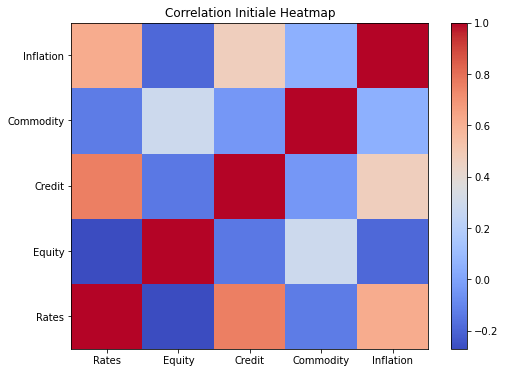

In [4]:
#corrélation
Correlation_initiale=Lens.corr()

# Create a heatmap using matplotlib
plt.figure(figsize=(8, 6))
heatmap = plt.pcolor(Correlation_initiale, cmap='coolwarm')

# Add colorbar
plt.colorbar(heatmap)

# Set ticks at the middle of each cell
plt.xticks(np.arange(0.5, len(Correlation_initiale.columns), 1), Correlation_initiale.columns)
plt.yticks(np.arange(0.5, len(Correlation_initiale.index), 1), Correlation_initiale.columns)


plt.title('Correlation Initiale Heatmap')
plt.show()

In [5]:
Correlation_initiale

,Rates,Equity,Credit,Commodity,Inflation
Rates,1.000000,-0.269855,0.757008,-0.126467,0.620891
Equity,-0.269855,1.000000,-0.136154,0.289524,-0.185852
Credit,0.757008,-0.136154,1.000000,-0.037419,0.473907
Commodity,-0.126467,0.289524,-0.037419,1.000000,0.050942
Inflation,0.620891,-0.185852,0.473907,0.050942,1.000000


## Exponentially-weighted regression

In [10]:
Lens_adj=Lens.copy(deep=True)
Lens_adj

,Rates,Equity,Credit,Commodity,Inflation
Date,,,,,
2000-02-29,0.003759,-0.020108,0.009480,0.017483,0.003851
2000-03-31,0.017624,0.096720,0.013444,0.009691,0.027533
2000-04-28,0.004521,-0.030796,0.001756,-0.012277,0.010153
2000-05-31,0.010839,-0.021915,-0.001363,0.067303,-0.002092
2000-06-30,0.005828,0.023934,0.004485,0.023599,0.011452
...,...,...,...,...,...
2021-12-27,0.000252,0.013839,0.000068,0.014942,0.004043
2021-12-28,0.000233,-0.001010,-0.000034,-0.003172,0.000000
2021-12-29,-0.002544,0.001402,-0.002433,0.001292,-0.000626


In [7]:
# Define the rolling window size
rolling_window = 252  # Assuming daily returns with approximately 252 trading days in a year

# Exponentially weighted residualization process using pd.ewm() and pd.DataFrame.rolling()
def ewm_residualize(donnees, dependent_column, independent_columns, span):
    result = pd.DataFrame(index=donnees.index)
    
    for col in independent_columns:
        # Calculate EWMA of the independent variable
        ewma_x = donnees[col].ewm(span=span).mean()

        # Calculate EWMA of the dependent variable
        ewma_y = donnees[dependent_column].ewm(span=span).mean()

        # Calculate residuals using rolling regression
        residuals = donnees[dependent_column] - ewma_y
        for i in range(rolling_window, len(donnees)):
            window_data = donnees[i - rolling_window:i + 1]
            window_ewma_x = ewma_x[i - rolling_window:i + 1]

            # Rolling regression to calculate residuals
            X = np.column_stack((np.ones_like(window_ewma_x), window_ewma_x))
            beta = np.linalg.lstsq(X, window_data[dependent_column], rcond=None)[0]
            residuals.iloc[i] = window_data[dependent_column].iloc[-1] - np.dot(X[-1, :], beta)

        result[col + '_residual'] = residuals
    
    return result

In [8]:
#Test sur la colonne Credit

# Apply exponentially weighted residualization to Credit returns with Interest Rates and Equity
span_parameter = 20  # Adjust span parameter based on preferences
residualized_data = ewm_residualize(Lens_adj, 'Credit', ['Rates', 'Equity'], span_parameter)

# Display the results
print(residualized_data)

            Rates_residual  Equity_residual
Date                                       
2000-02-29        0.000000         0.000000
2000-03-31        0.001883         0.001883
2000-04-28       -0.006205        -0.006205
2000-05-31       -0.006632        -0.006632
2000-06-30       -0.000594        -0.000594
...                    ...              ...
2021-12-27        0.000331        -0.000040
2021-12-28        0.000170        -0.000112
2021-12-29       -0.001905        -0.002480
2021-12-30        0.000626         0.000114
2021-12-31        0.000658         0.000238

[4952 rows x 2 columns]


In [14]:
span_parameter = 20  # Adjust span parameter based on preferences
#residualized_data = ewm_residualize(Returns, 'Credit', ['Rates', 'Equity'], span_parameter)
for i in range(2,len(Lens_adj.columns)):
    residualized_data = ewm_residualize(Lens_adj, Lens_adj.columns[i], ['Rates', 'Equity'], span_parameter)
    for d in range(len(Lens_adj.index)):
        for j in residualized_data.columns:
            Lens_adj.iloc[d,i]=Lens_adj.iloc[d,i]-residualized_data[j].iloc[d]

Lens_adj

,Rates,Equity,Credit,Commodity,Inflation
Date,,,,,
2000-02-29,0.003759,-0.020108,0.009480,0.017483,0.003851
2000-03-31,0.017624,0.096720,0.009678,0.017093,0.005035
2000-04-28,0.004521,-0.030796,0.014166,0.020210,0.017913
2000-05-31,0.010839,-0.021915,0.011901,-0.022801,0.020848
2000-06-30,0.005828,0.023934,0.005674,0.021555,0.008307
...,...,...,...,...,...
2021-12-27,0.000252,0.013839,-0.000223,-0.009607,-0.003232
2021-12-28,0.000233,-0.001010,-0.000091,0.007706,0.000748
2021-12-29,-0.002544,0.001402,0.001953,0.003382,0.000943


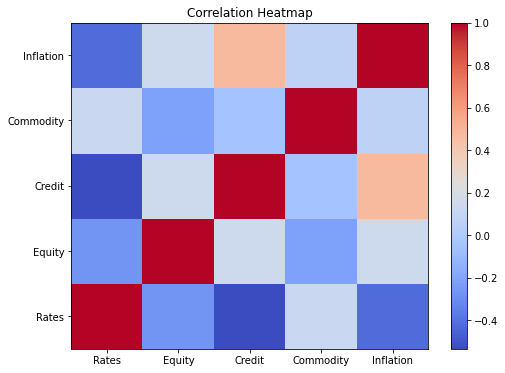

In [15]:
#corrélation
Correlation_apres_traitement=Lens_adj.corr()

# Create a heatmap using matplotlib
plt.figure(figsize=(8, 6))
heatmap = plt.pcolor(Correlation_apres_traitement, cmap='coolwarm')

# Add colorbar
plt.colorbar(heatmap)

# Set ticks at the middle of each cell
plt.xticks(np.arange(0.5, len(Correlation_apres_traitement.columns), 1), Correlation_apres_traitement.columns)
plt.yticks(np.arange(0.5, len(Correlation_apres_traitement.index), 1), Correlation_apres_traitement.columns)


plt.title('Correlation Heatmap')
plt.show()

In [16]:
Correlation_initiale #Corrélations avant regression exponentielle

,Rates,Equity,Credit,Commodity,Inflation
Rates,1.000000,-0.269855,0.757008,-0.126467,0.620891
Equity,-0.269855,1.000000,-0.136154,0.289524,-0.185852
Credit,0.757008,-0.136154,1.000000,-0.037419,0.473907
Commodity,-0.126467,0.289524,-0.037419,1.000000,0.050942
Inflation,0.620891,-0.185852,0.473907,0.050942,1.000000


In [17]:
Correlation_apres_traitement #Corrélations après régression exponentielle

,Rates,Equity,Credit,Commodity,Inflation
Rates,1.000000,-0.269855,-0.534250,0.121918,-0.422439
Equity,-0.269855,1.000000,0.145522,-0.212389,0.143742
Credit,-0.534250,0.145522,1.000000,-0.044699,0.475681
Commodity,0.121918,-0.212389,-0.044699,1.000000,0.065539
Inflation,-0.422439,0.143742,0.475681,0.065539,1.000000


## GMM

In [34]:
# Création des dataset pour s'entrainer et tester
df_train = Lens_adj[Lens_adj.index<pd.to_datetime('2010-01-01')]
df_test = Lens_adj[Lens_adj.index>pd.to_datetime('2010-01-01')]

num_states = 4  # Définissez le nombre d'états de marché
model = GaussianMixture(n_components=num_states)

# Ajustez le modèle
model.fit(df_train)

# 4. Identification des états de marché
market_states = model.predict(df_test)
Proba_market_states=model.predict_proba(df_test)

# Ajoutez les états de marché en tant que colonne dans les données
res=np.column_stack((df_test, market_states,Proba_market_states))
res=pd.DataFrame(res,index=df_test.index,columns=['Rates','Equity','Credit','Commodity','Inflation','Market_State','0','1','2','3'])
res #rendements journaliers

,Rates,Equity,Credit,Commodity,Inflation,Market_State,0,1,2,3
Date,,,,,,,,,,
2010-01-04,0.000234,0.016043,-0.001101,-0.017598,-0.001371,1.0,0.002285,0.673971,0.000927,0.322817
2010-01-05,0.001241,0.003116,-0.000949,0.005841,-0.003107,3.0,0.000176,0.110679,0.000036,0.889109
2010-01-06,-0.001660,0.000546,0.000071,-0.015626,0.001326,3.0,0.000477,0.243081,0.000320,0.756123
2010-01-07,0.000519,0.004001,-0.002028,0.019827,-0.001856,3.0,0.000835,0.283352,0.000268,0.715545
2010-01-08,0.000353,0.002882,-0.000379,0.007665,-0.001684,3.0,0.000137,0.099595,0.000042,0.900226
...,...,...,...,...,...,...,...,...,...,...
2021-12-27,0.000252,0.013839,-0.000223,-0.009607,-0.003232,3.0,0.001022,0.365436,0.000208,0.633334
2021-12-28,0.000233,-0.001010,-0.000091,0.007706,0.000748,3.0,0.000107,0.098291,0.000053,0.901549
2021-12-29,-0.002544,0.001402,0.001953,0.003382,0.000943,3.0,0.000192,0.089956,0.000105,0.909747


In [35]:
# Affichez les statistiques des différents états de marché
for state in range(num_states):
    state_data = res[res['Market_State'] == state]
    print("\n ------------------------------------------- \n")
    print(f"État de marché {state} - Nombre d'observations : {len(state_data)}")
    print(state_data.iloc[:,:5].describe()) 


 ------------------------------------------- 

État de marché 0 - Nombre d'observations : 24
           Rates     Equity     Credit  Commodity  Inflation
count  24.000000  24.000000  24.000000  24.000000  24.000000
mean   -0.001267   0.005889   0.001460  -0.006471   0.001228
std     0.005809   0.057651   0.006149   0.020878   0.015056
min    -0.009681  -0.119841  -0.017364  -0.050135  -0.033654
25%    -0.006926  -0.032810  -0.000779  -0.016019  -0.006726
50%    -0.001454   0.008433   0.001370  -0.007563   0.003070
75%     0.003424   0.051692   0.005998   0.008356   0.011170
max     0.008885   0.093828   0.010194   0.043905   0.024213

 ------------------------------------------- 

État de marché 1 - Nombre d'observations : 455
            Rates      Equity      Credit   Commodity   Inflation
count  455.000000  455.000000  455.000000  455.000000  455.000000
mean     0.000416   -0.003296    0.000237   -0.001743    0.000480
std      0.002282    0.019589    0.002042    0.013484    0.00459

In [36]:
res_annuel=res.copy(deep=True)

for col in res_annuel.columns[:5]:
    res_annuel[col]=res_annuel[col]*np.sqrt(252)

res_annuel

,Rates,Equity,Credit,Commodity,Inflation,Market_State,0,1,2,3
Date,,,,,,,,,,
2010-01-04,0.003723,0.254681,-0.017480,-0.279354,-0.021763,1.0,0.002285,0.673971,0.000927,0.322817
2010-01-05,0.019707,0.049460,-0.015062,0.092725,-0.049319,3.0,0.000176,0.110679,0.000036,0.889109
2010-01-06,-0.026348,0.008660,0.001129,-0.248061,0.021053,3.0,0.000477,0.243081,0.000320,0.756123
2010-01-07,0.008235,0.063517,-0.032190,0.314744,-0.029459,3.0,0.000835,0.283352,0.000268,0.715545
2010-01-08,0.005609,0.045746,-0.006016,0.121684,-0.026730,3.0,0.000137,0.099595,0.000042,0.900226
...,...,...,...,...,...,...,...,...,...,...
2021-12-27,0.004006,0.219686,-0.003544,-0.152514,-0.051309,3.0,0.001022,0.365436,0.000208,0.633334
2021-12-28,0.003701,-0.016036,-0.001442,0.122334,0.011881,3.0,0.000107,0.098291,0.000053,0.901549
2021-12-29,-0.040378,0.022254,0.030999,0.053680,0.014967,3.0,0.000192,0.089956,0.000105,0.909747


In [37]:
# Affichez les statistiques des différents états de marché
for state in range(num_states):
    state_data = res_annuel[res_annuel['Market_State'] == state]
    print("\n ------------------------------------------- \n")
    print(f"État de marché {state} - Nombre d'observations : {len(state_data)}")
    print(state_data.iloc[:,:5].describe()) 


 ------------------------------------------- 

État de marché 0 - Nombre d'observations : 24
           Rates     Equity     Credit  Commodity  Inflation
count  24.000000  24.000000  24.000000  24.000000  24.000000
mean   -0.020121   0.093480   0.023171  -0.102728   0.019487
std     0.092222   0.915182   0.097605   0.331422   0.239014
min    -0.153675  -1.902410  -0.275645  -0.795872  -0.534237
25%    -0.109945  -0.520847  -0.012374  -0.254298  -0.106777
50%    -0.023081   0.133872   0.021745  -0.120060   0.048737
75%     0.054354   0.820593   0.095213   0.132652   0.177314
max     0.141039   1.489469   0.161824   0.696972   0.384363

 ------------------------------------------- 

État de marché 1 - Nombre d'observations : 455
            Rates      Equity      Credit   Commodity   Inflation
count  455.000000  455.000000  455.000000  455.000000  455.000000
mean     0.006598   -0.052316    0.003756   -0.027666    0.007625
std      0.036223    0.310969    0.032408    0.214059    0.07301

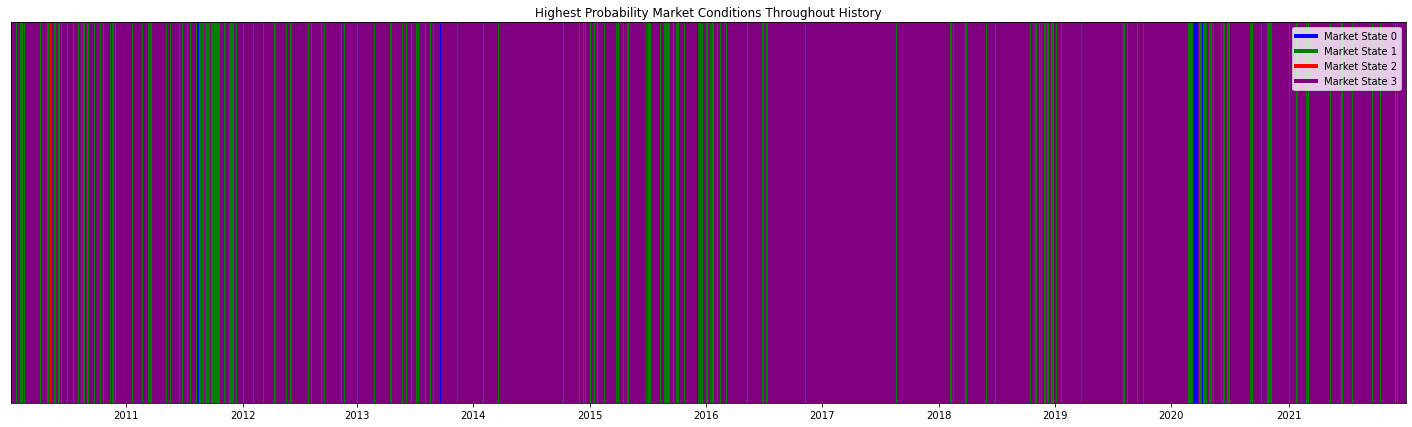

In [51]:
# Couleurs pour chaque régime de marché
colors = {'0': 'blue', '1': 'green', '2': 'red', '3': 'purple'}

# Création d'une figure pour la frise
fig, ax = plt.subplots(figsize=(25, 7))

# Hauteur du rectangle pour la frise
rectangle_height = 1

# Tracé des rectangles pour chaque date
for i, date in enumerate(res.index):
    # Déterminer la couleur en fonction du régime de marché
    market_state = str(int(res.at[date, 'Market_State']))  # Conversion en chaîne après conversion en entier
    color = colors[market_state]
    
    # Création du rectangle
    rect = patches.Rectangle((i, 0), 1, rectangle_height, color=color)
    ax.add_patch(rect)

# Configuration de l'axe des x pour afficher uniquement les années
years = [date.year for date in res.index]
change_years = [i for i in range(1, len(years)) if years[i] != years[i-1]]
ax.set_xticks(change_years)
ax.set_xticklabels([years[i] for i in change_years])

# Configuration des limites de l'axe
ax.set_xlim(0, len(res))
ax.set_ylim(0, rectangle_height)
ax.set_yticks([])  # Pas de marques sur l'axe des y

# Création d'une légende pour les états de marché
legend_elements = [Line2D([0], [0], color=color, lw=4, label=f'Market State {state}') for state, color in colors.items()]
ax.legend(handles=legend_elements, loc='upper right')

# Titre et affichage du graphique
ax.set_title('Highest Probability Market Conditions Throughout History')
plt.show()

In [39]:
#Résultats en pourcentage
res_pct=res_annuel.copy(deep=True)

for col in res_pct.columns[:5]:
    res_pct[col]=res_pct[col]*100

res_pct

,Rates,Equity,Credit,Commodity,Inflation,Market_State,0,1,2,3
Date,,,,,,,,,,
2010-01-04,0.372251,25.468136,-1.747996,-27.935440,-2.176335,1.0,0.002285,0.673971,0.000927,0.322817
2010-01-05,1.970726,4.945982,-1.506229,9.272539,-4.931860,3.0,0.000176,0.110679,0.000036,0.889109
2010-01-06,-2.634816,0.865987,0.112898,-24.806086,2.105265,3.0,0.000477,0.243081,0.000320,0.756123
2010-01-07,0.823541,6.351711,-3.218980,31.474450,-2.945932,3.0,0.000835,0.283352,0.000268,0.715545
2010-01-08,0.560883,4.574600,-0.601555,12.168365,-2.673018,3.0,0.000137,0.099595,0.000042,0.900226
...,...,...,...,...,...,...,...,...,...,...
2021-12-27,0.400645,21.968629,-0.354405,-15.251365,-5.130866,3.0,0.001022,0.365436,0.000208,0.633334
2021-12-28,0.370120,-1.603571,-0.144207,12.233426,1.188110,3.0,0.000107,0.098291,0.000053,0.901549
2021-12-29,-4.037826,2.225440,3.099863,5.367973,1.496677,3.0,0.000192,0.089956,0.000105,0.909747


In [40]:
# Affichez les statistiques des différents états de marché en bp
for state in range(num_states):
    state_data = res_pct[res_pct['Market_State'] == state]
    print("\n ------------------------------------------- \n")
    print(f"État de marché {state} - Nombre d'observations : {len(state_data)}")
    print(state_data.iloc[:,:5].describe()) 


 ------------------------------------------- 

État de marché 0 - Nombre d'observations : 24
           Rates      Equity     Credit  Commodity  Inflation
count  24.000000   24.000000  24.000000  24.000000  24.000000
mean   -2.012067    9.348025   2.317080 -10.272761   1.948692
std     9.222224   91.518236   9.760526  33.142209  23.901418
min   -15.367513 -190.240979 -27.564450 -79.587189 -53.423704
25%   -10.994497  -52.084703  -1.237401 -25.429808 -10.677723
50%    -2.308136   13.387155   2.174497 -12.005961   4.873661
75%     5.435377   82.059299   9.521346  13.265237  17.731439
max    14.103858  148.946919  16.182446  69.697221  38.436295

 ------------------------------------------- 

État de marché 1 - Nombre d'observations : 455
            Rates      Equity      Credit   Commodity   Inflation
count  455.000000  455.000000  455.000000  455.000000  455.000000
mean     0.659832   -5.231640    0.375592   -2.766580    0.762490
std      3.622295   31.096909    3.240827   21.405922  

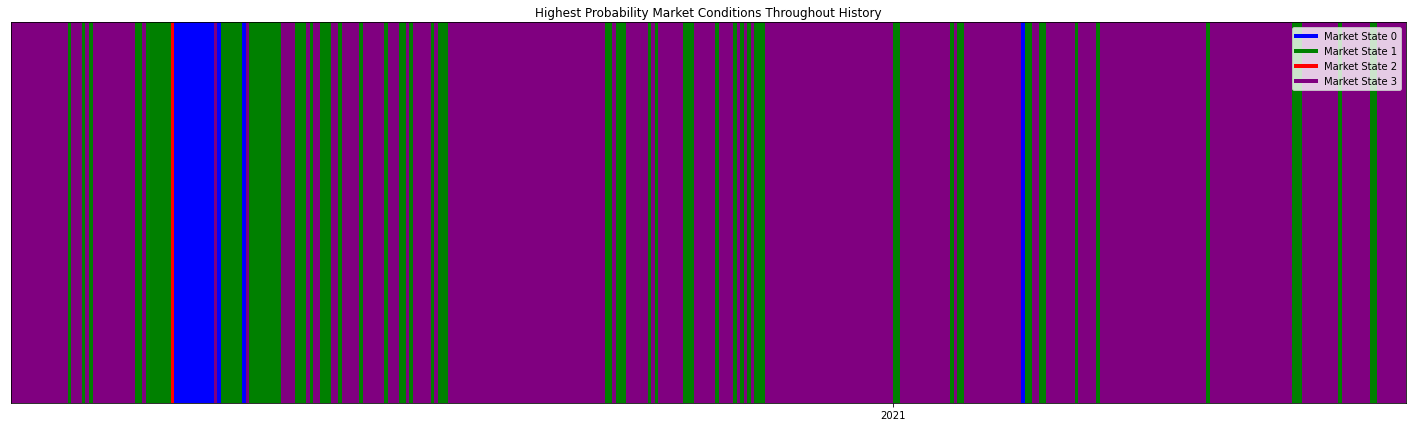

In [58]:
# Couleurs pour chaque régime de marché
colors = {'0': 'blue', '1': 'green', '2': 'red', '3': 'purple'}

# Création d'une figure pour la frise
fig, ax = plt.subplots(figsize=(25, 7))

# Hauteur du rectangle pour la frise
rectangle_height = 1

# Tracé des rectangles pour chaque date
for i, date in enumerate(res.index[2458:2850]):
    # Déterminer la couleur en fonction du régime de marché
    market_state = str(int(res.at[date, 'Market_State']))  # Conversion en chaîne après conversion en entier
    color = colors[market_state]
    
    # Création du rectangle
    rect = patches.Rectangle((i, 0), 1, rectangle_height, color=color)
    ax.add_patch(rect)

# Configuration de l'axe des x pour afficher uniquement les années
years = [date.year for date in res.index[2458:2850]]
change_years = [i for i in range(1, len(years)) if years[i] != years[i-1]]
ax.set_xticks(change_years)
ax.set_xticklabels([years[i] for i in change_years])

# Configuration des limites de l'axe
ax.set_xlim(0, len(res[2458:2850]))
ax.set_ylim(0, rectangle_height)
ax.set_yticks([])  # Pas de marques sur l'axe des y

# Création d'une légende pour les états de marché
legend_elements = [Line2D([0], [0], color=color, lw=4, label=f'Market State {state}') for state, color in colors.items()]
ax.legend(handles=legend_elements, loc='upper right')

# Titre et affichage du graphique
ax.set_title('Highest Probability Market Conditions Throughout History')
plt.show()

In [57]:
res.index[2458:2850]

DatetimeIndex(['2020-01-02', '2020-01-03', '2020-01-06', '2020-01-07',
               '2020-01-08', '2020-01-09', '2020-01-10', '2020-01-13',
               '2020-01-14', '2020-01-15',
               ...
               '2021-07-19', '2021-07-20', '2021-07-21', '2021-07-22',
               '2021-07-23', '2021-07-26', '2021-07-27', '2021-07-28',
               '2021-07-29', '2021-07-30'],
              dtype='datetime64[ns]', name='Date', length=392, freq=None)

In [60]:
res.iloc[:,6:]

,0,1,2,3
Date,,,,
2010-01-04,0.002285,0.673971,0.000927,0.322817
2010-01-05,0.000176,0.110679,0.000036,0.889109
2010-01-06,0.000477,0.243081,0.000320,0.756123
2010-01-07,0.000835,0.283352,0.000268,0.715545
2010-01-08,0.000137,0.099595,0.000042,0.900226
...,...,...,...,...
2021-12-27,0.001022,0.365436,0.000208,0.633334
2021-12-28,0.000107,0.098291,0.000053,0.901549
2021-12-29,0.000192,0.089956,0.000105,0.909747


In [61]:
# Chemin du fichier CSV
chemin_fichier_csv = "/Users/thomascgd/Desktop/Esilv/A5/PI2/GMM_Proba.csv"

res.iloc[:,6:].to_csv(chemin_fichier_csv,index=True)

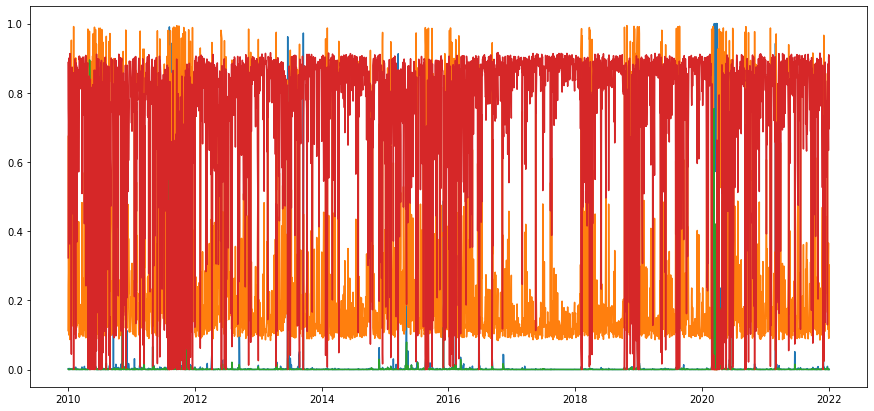

In [64]:
plt.figure(figsize=(15,7))
plt.plot(res.iloc[:,6:])